In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import pandas as pd
import cython
from scipy.optimize import curve_fit
from lmfit.models import ExponentialModel, GaussianModel, Model

import uproot4 as up
from nicks_plot_utils import Hist2D, Hist1D

import warnings
warnings.filterwarnings('ignore')

masses = {
    "P" : 0.93827203,
    "PIP" : 0.13957018,
    "KAON" : 0.493677
}
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

COLOR_BLUE='#348ABD'
COLOR_RED='#A60628'

['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']


In [2]:
%%cython --annotate
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt
cimport cython

cdef float c_special_units = 29.9792458
cdef float MASS_PIP = 0.13957018


@cython.nonecheck(False)
@cython.cdivision(True)
cdef float dt_calc(float mass, float vertex, float momentum, float sc_t, float sc_r):
    if momentum == 0 or sc_t == 0 or sc_r == 0:
        return 100
    cdef float r_beta = 1.0 / sqrt(1.0 + (mass / momentum) * (mass / momentum))
    cdef float vt = sc_t - sc_r / (r_beta * c_special_units)
    
    return vertex - vt

@np.vectorize
def calc_dt(float mass, float vertex, float momentum, float sc_t, float sc_r):
    return dt_calc(mass, vertex, momentum, sc_t, sc_r)


In [3]:
data = pd.read_csv("/Users/tylern/Data/e1d/dt_fit.csv")
print(len(data))
data = data.replace(0, np.nan)
data = data.dropna()
print(len(data))

16833653
9488292


In [4]:
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r
0,5.0,0.673603,-2.473710,-1.0,51.7974,0.882316,68.8019,505.513
1,1.0,1.000850,1.895650,1.0,56.9760,0.527272,73.6819,485.990
2,4.0,1.167810,-1.890120,1.0,51.4494,0.426896,65.6514,464.723
5,3.0,0.285894,-0.760889,1.0,54.7548,2.263920,72.7552,498.357
6,3.0,0.880925,-0.758683,1.0,54.7548,0.471126,71.5546,480.188


In [5]:
%time
for mass in masses:
    data[f"dt_{mass}"] = calc_dt(masses[mass], data.vertex, data.p, data.sc_t, data.sc_r)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 9.06 µs


In [6]:
data = data.dropna()
#data = data[(data.theta < 1.0) & (np.abs(data.dt_PIP) < 1.2)]
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r,dt_P,dt_PIP,dt_KAON
0,5.0,0.673603,-2.473710,-1.0,51.7974,0.882316,68.8019,505.513,7.609894,0.067261,2.317635
1,1.0,1.000850,1.895650,1.0,56.9760,0.527272,73.6819,485.990,16.384014,0.063297,5.501411
2,4.0,1.167810,-1.890120,1.0,51.4494,0.426896,65.6514,464.723,23.229328,2.106949,9.497238
5,3.0,0.285894,-0.760889,1.0,54.7548,2.263920,72.7552,498.357,-0.005890,-1.345444,-0.986359
6,3.0,0.880925,-0.758683,1.0,54.7548,0.471126,71.5546,480.188,18.895100,-0.094372,6.400612


In [7]:
def two_gauss(x, *p):
    A, mu, sigma, A2, mu2, sigma2 = p
    g1 = A*np.exp(-(x-mu)**2/(2.*sigma**2))
    g2 = A2*np.exp(-(x-mu2)**2/(2.*sigma2**2))
    return g1+g2

def gauss(x, *p):
    A, mu, sigma = p
    g1 = A*np.exp(-(x-mu)**2/(2.*sigma**2))
    return g1

def poly(x, a, b, c, d, e):
    # a*x**4 + b*x**3 +
    y = c*x**2 + d*x + e
    return y


def log_pol1(x, a, b, c, d, e, f):
    y = a*np.log(b*x) + c*x*np.sqrt(d*x) + e*x + f
    return y



def get_slices(data, sec=1, charge=1, min_p = 0.0, max_p = 4.0, num_steps = 20, particle="dt_P", show=False):
    slices = []
    mom = np.linspace(min_p, max_p, num=num_steps, endpoint=True)
    
    if sec != 0:
        d = data[(data.charge == charge) & (data.sec == sec)]
    else:
        d = data[(data.charge == charge)]
        
    
    for m in range(len(mom[:-1])):
        _min = mom[m]
        _max = mom[m+1]
        slic = d[(d.p > _min) & (d.p <= _max)]
        if len(slic) > 10:
            if show:
                ydata, xdata = np.histogram(slic[particle], bins=200, range=(-5,5))
                x=xdata
                y=ydata
                x = (x[1:]+x[:-1])/2.0
                
                gauss1 = GaussianModel(prefix='g1_')
                pars = gauss1.guess(y, x=x)
                pars.update(gauss1.make_params())
                pars['g1_center'].set(value=0, min=-0.5, max=0.5)
                pars['g1_amplitude'].set(value=10, min=0)
                
                gauss2 = GaussianModel(prefix='g2_')
                pars.update(gauss2.make_params())
                if particle=="dt_PIP":
                    pars['g2_center'].set(value=-2.0, min=-5.0, max=0.0)
                else:
                    pars['g2_center'].set(value=2.0, min=0.0, max=5.0)
                pars['g2_amplitude'].set(value=10, min=0)
                
                

                mod = gauss1 + gauss2

                init = mod.eval(pars, x=x)
                out = mod.fit(y, pars, x=x)

                fig, axes = plt.subplots(figsize=(12.8, 4.8))
                comps = out.eval_components(x=x)
                axes.scatter(x, y)
                axes.plot(x, comps['g1_'], '--', label=f"$\mu$ = {out.params['g1_center'].value:0.4f} $\sigma$ = {out.params['g1_center'].value:0.4f}")
                axes.plot(x, comps['g2_'], '--', label=f"")
                # axes.plot(x, out.best_fit, '--', label='best fit')
                axes.legend(loc='upper left')
                
            else:
                ydata, xdata = np.histogram(slic[particle], bins=200, range=(-5,5))
                
            xdata = (xdata[1:] + xdata[:-1])/2.0
            try:
                p0 = [1.0, 0.0, 0.01]
                param_bounds=((0,    -0.5,  0),
                              (np.inf,0.5,  1.0)
                             )
                popt, pcov = curve_fit(gauss, xdata, ydata, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)

                if popt[2] > 0.4:
                    x2 = xdata[xdata>-0.8]
                    y2 = ydata[xdata>-0.8]
                    popt, pcov = curve_fit(gauss, x2, y2, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)
                
#                 if show:
#                     plt.plot(xdata, gauss(xdata, *popt), 'r-',
#                         label='fit: A=%5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
#                     plt.legend()
                if popt[2] < 1.0 and popt[1] < 1E-5:
                    slices.append([(_min+_max)/2.0, popt[1], popt[2]])
            except RuntimeError:
                try:
                    p0 = [1.0, 0.0, 0.01]
                    param_bounds=((0,    -0.5,  0),
                                  (np.inf,0.5,  0.5)
                             )
                    popt, pcov = curve_fit(gauss, xdata, ydata, p0=p0, 
                                           bounds=param_bounds, method="trf", maxfev=10000)
#                     if show:
#                         plt.plot(xdata, gauss(xdata, *popt), 'r--',
#                              label='fit: A=%5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
#                         plt.legend()
                        
                    if popt[2] < 1.0 and popt[1] < 1E-5:
                        slices.append([(_min+_max)/2.0, popt[1], popt[2]])
                except RuntimeError:
                    pass
            else:
                pass
            
            if show:
                plt.show()
                
    return np.array(slices).T

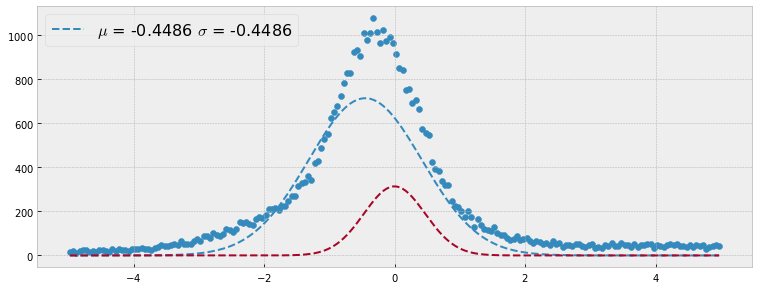

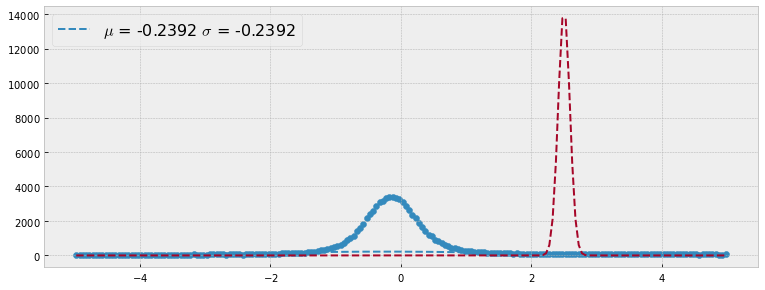

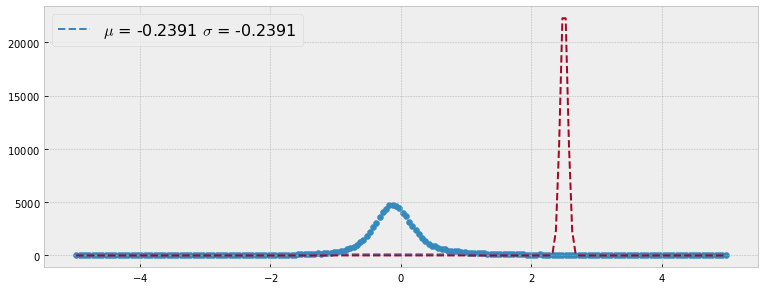

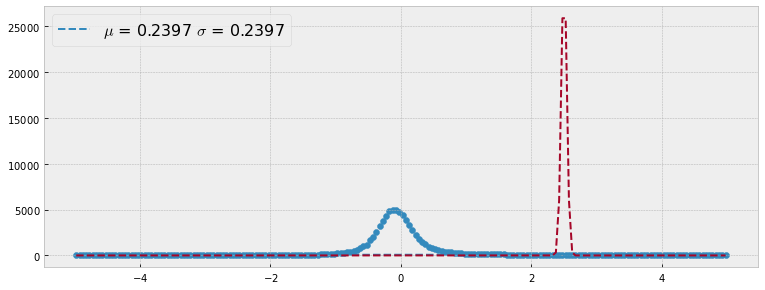

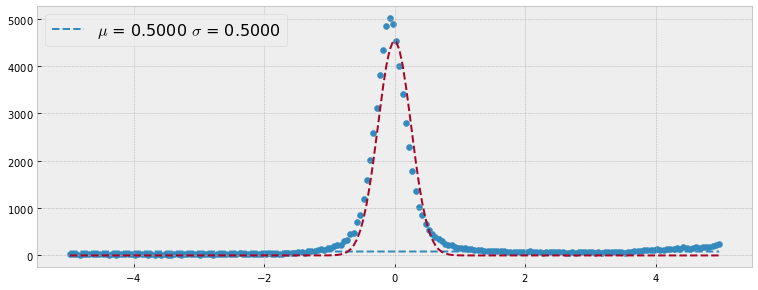

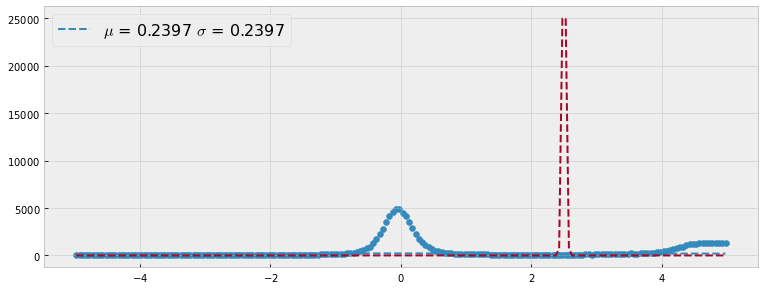

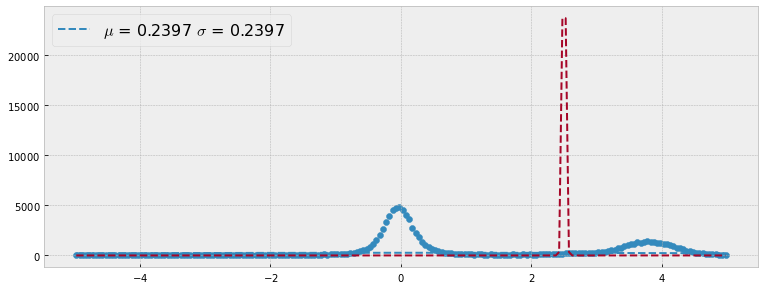

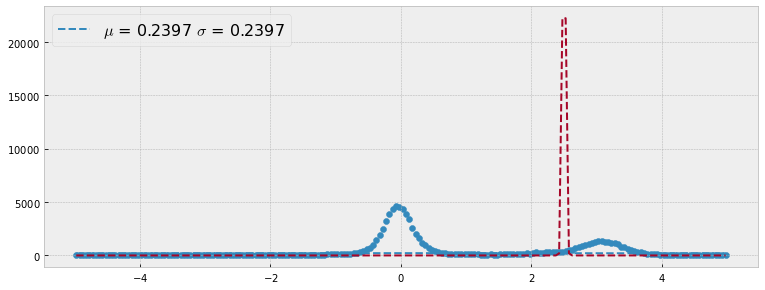

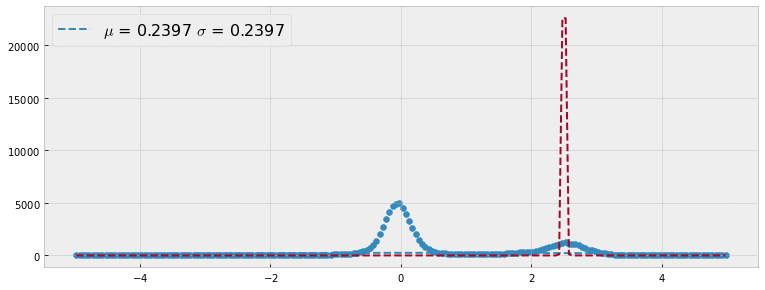

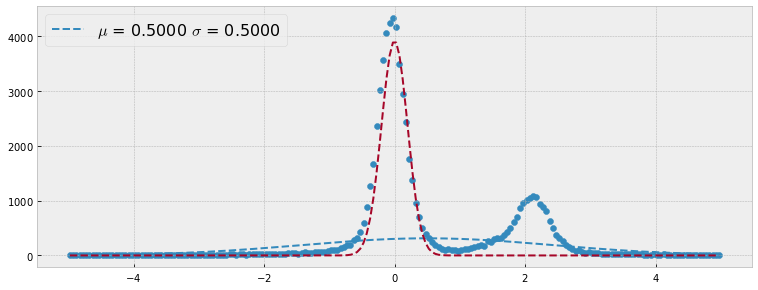

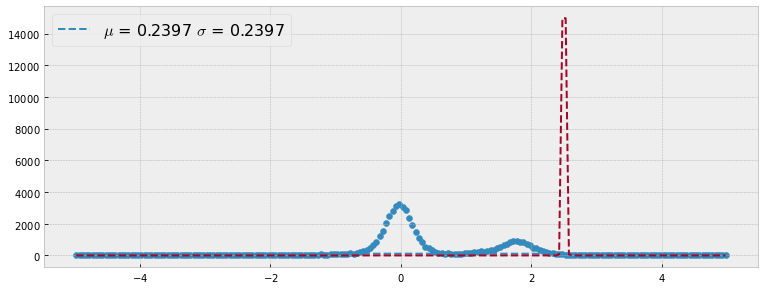

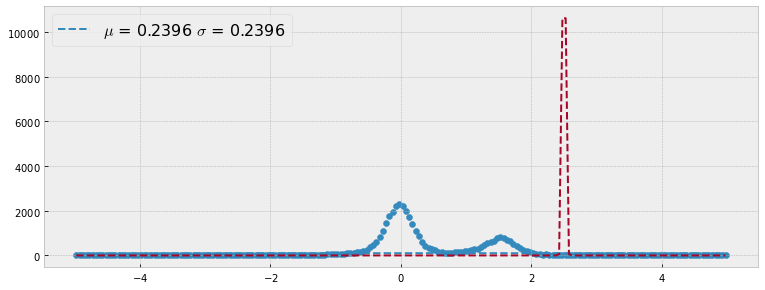

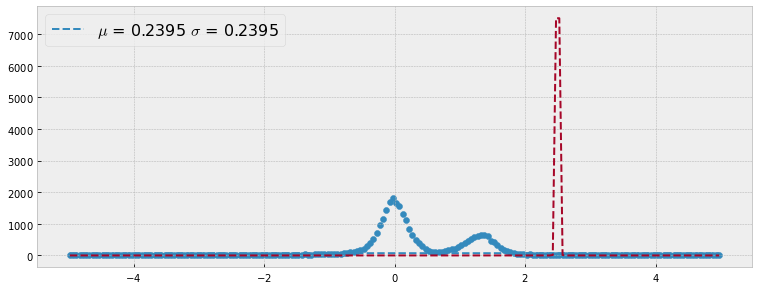

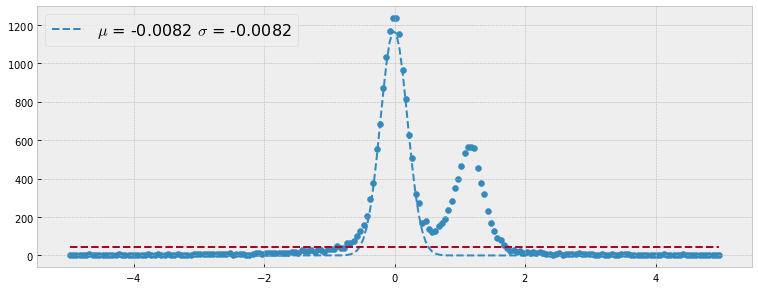

In [8]:
slices = get_slices(data, min_p = 0.3, max_p = 2.5, num_steps = 15, show=True)

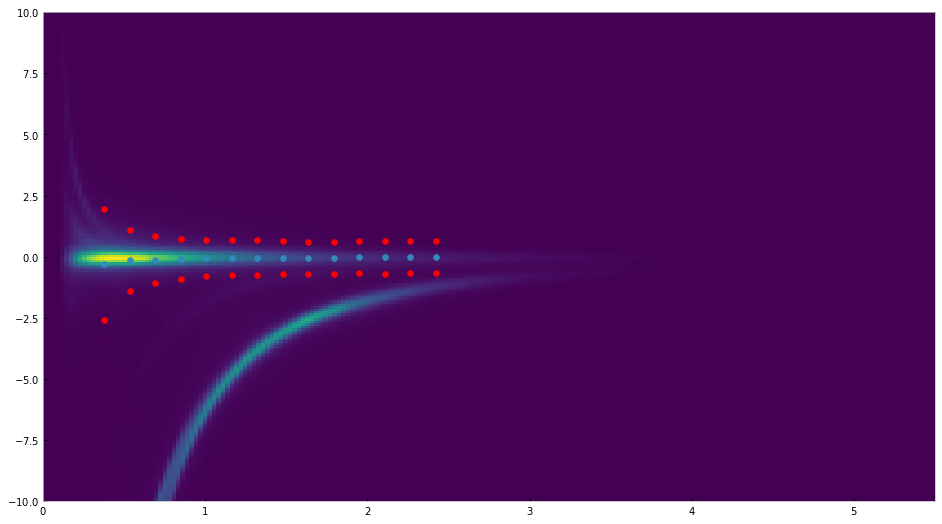

In [9]:
slice_p = slices[0]
mu = slices[1]
sigma = slices[2]

fig = plt.figure(figsize=(16,9))
plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 5.5),(-10.0,10.0)))
plt.scatter(slice_p, mu)
plt.scatter(slice_p, mu+3*sigma, c='r')
plt.scatter(slice_p, mu-3*sigma, c='r')
plt.show()

No handles with labels found to put in legend.


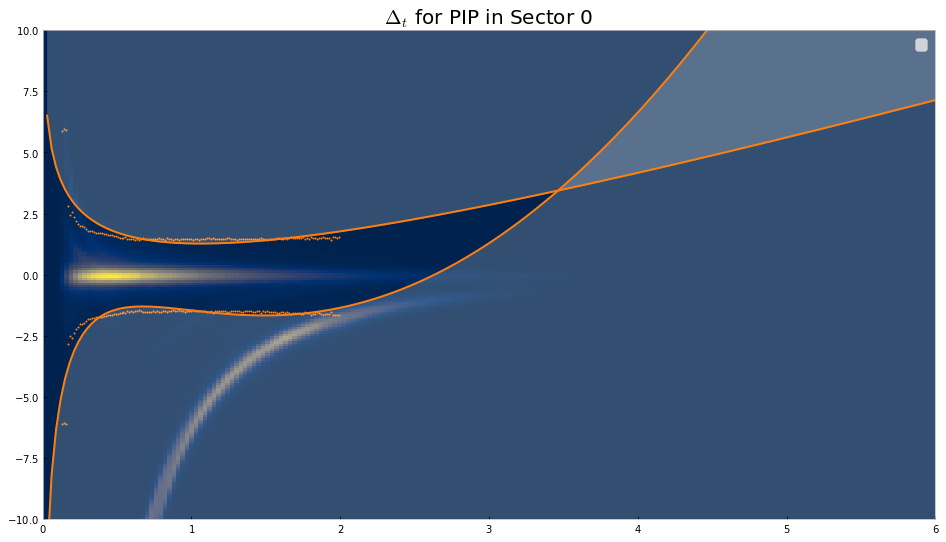

No handles with labels found to put in legend.


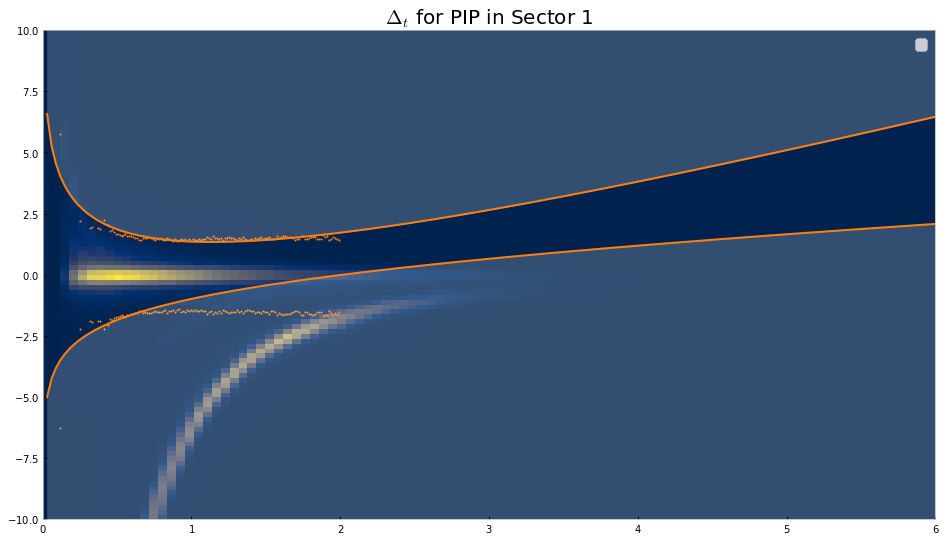

No handles with labels found to put in legend.


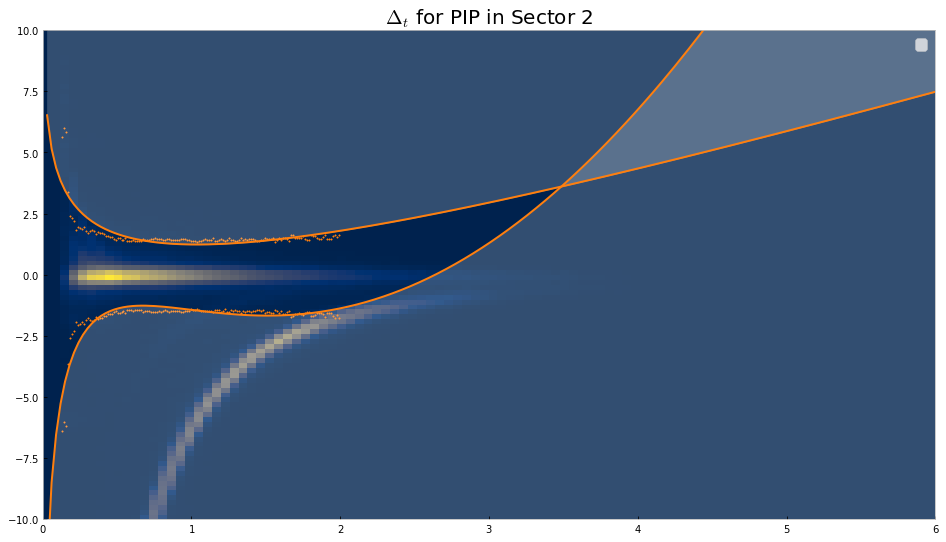

No handles with labels found to put in legend.


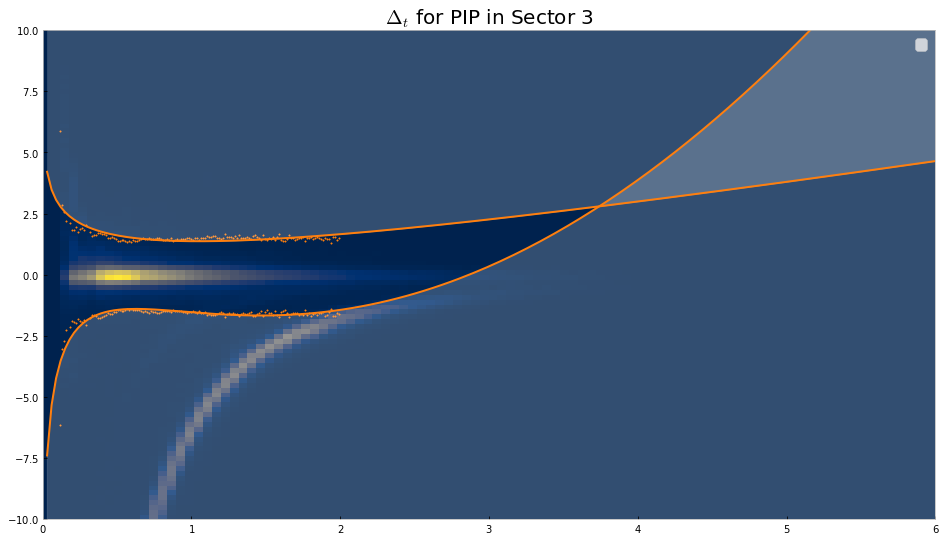

No handles with labels found to put in legend.


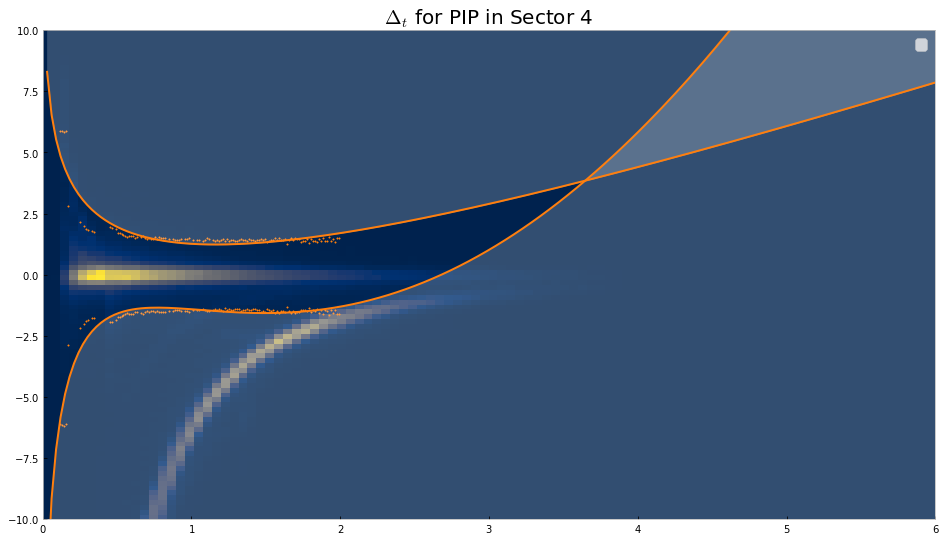

No handles with labels found to put in legend.


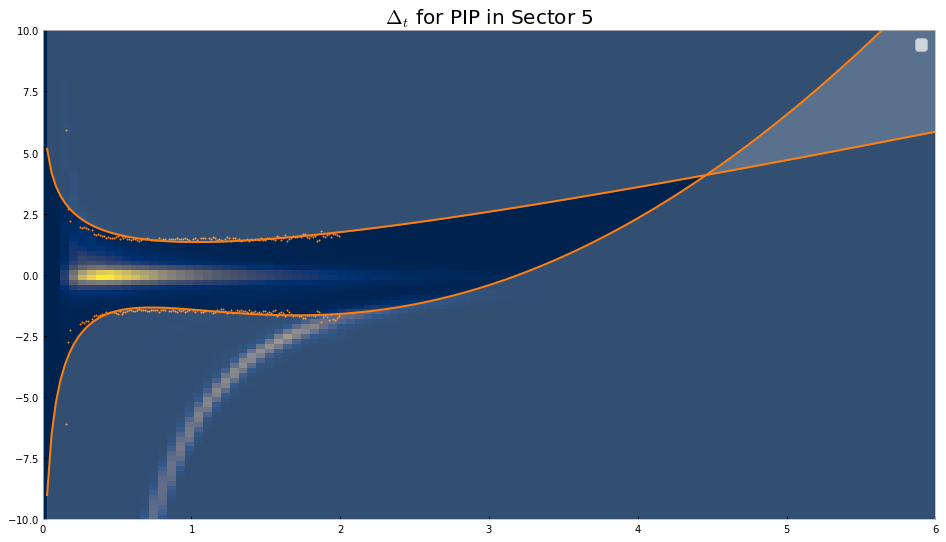

No handles with labels found to put in legend.


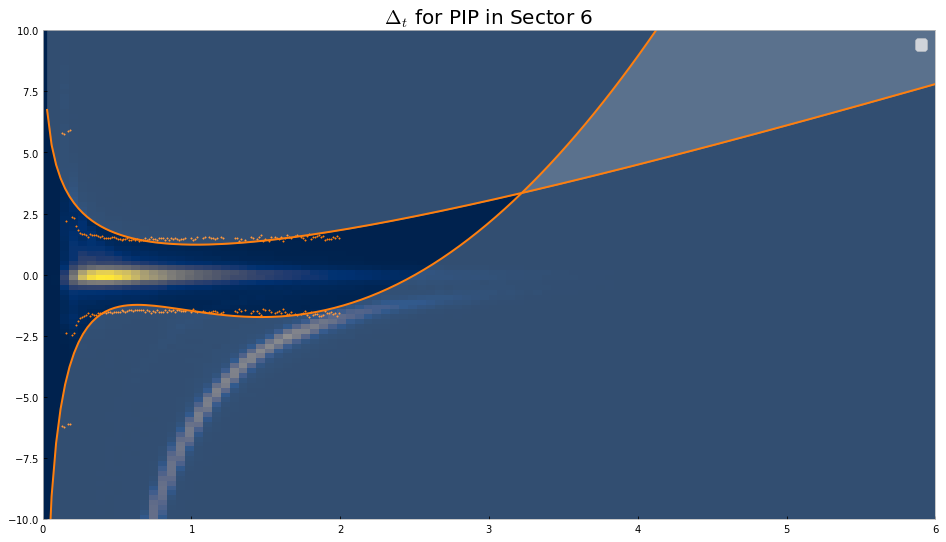

No handles with labels found to put in legend.


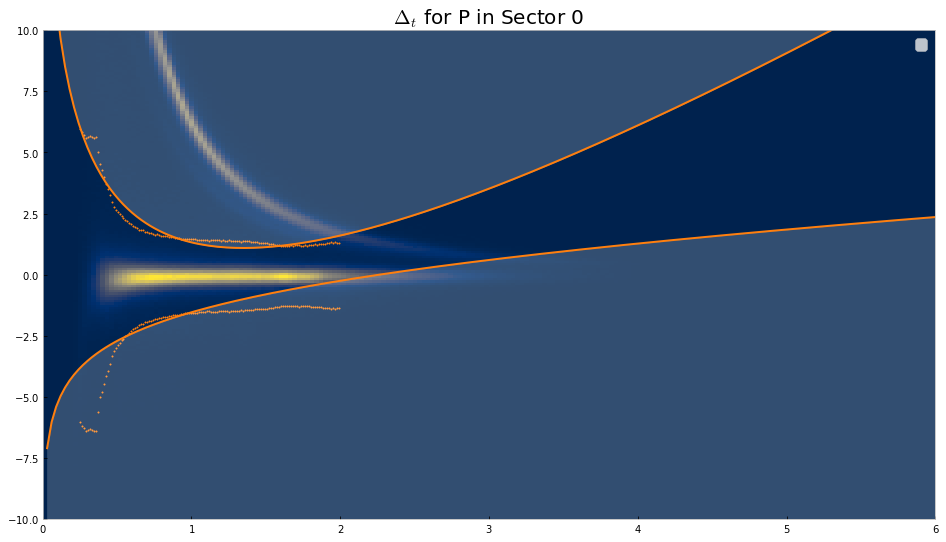

No handles with labels found to put in legend.


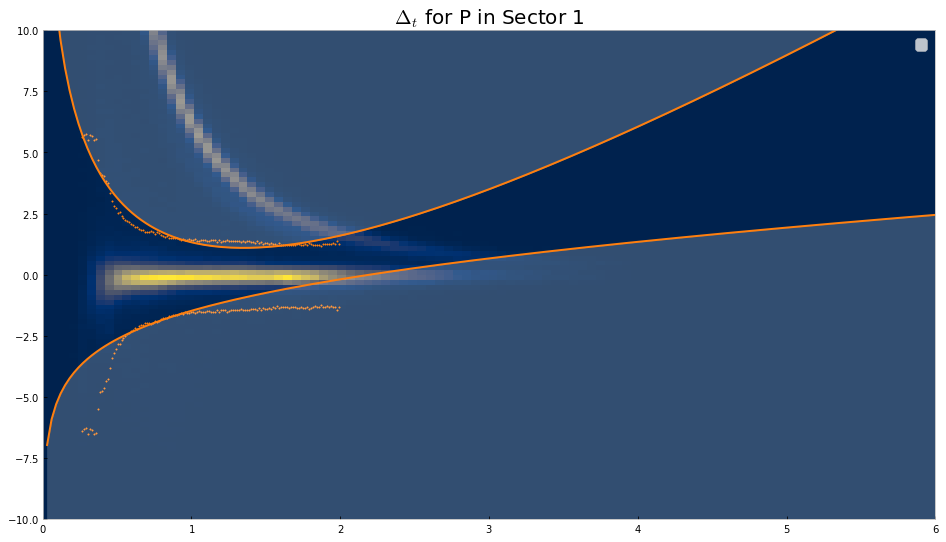

No handles with labels found to put in legend.


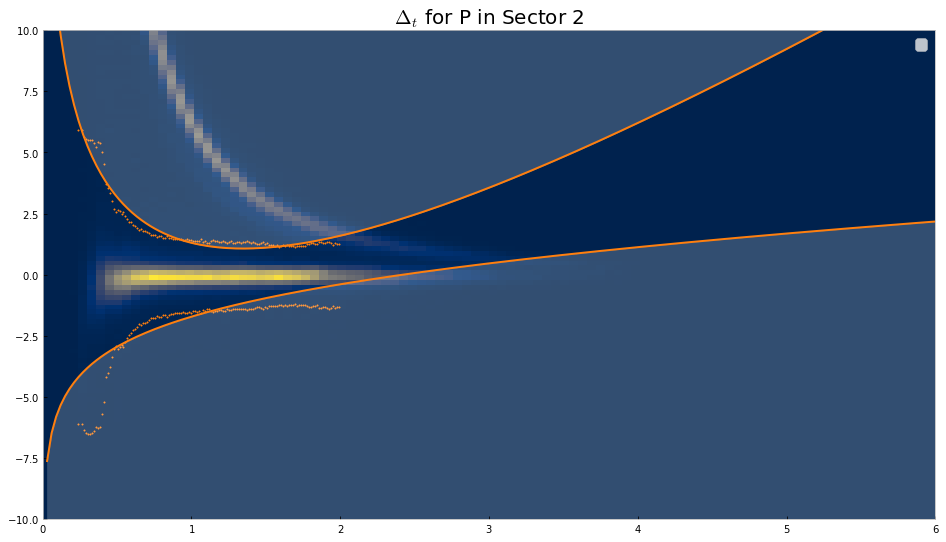

No handles with labels found to put in legend.


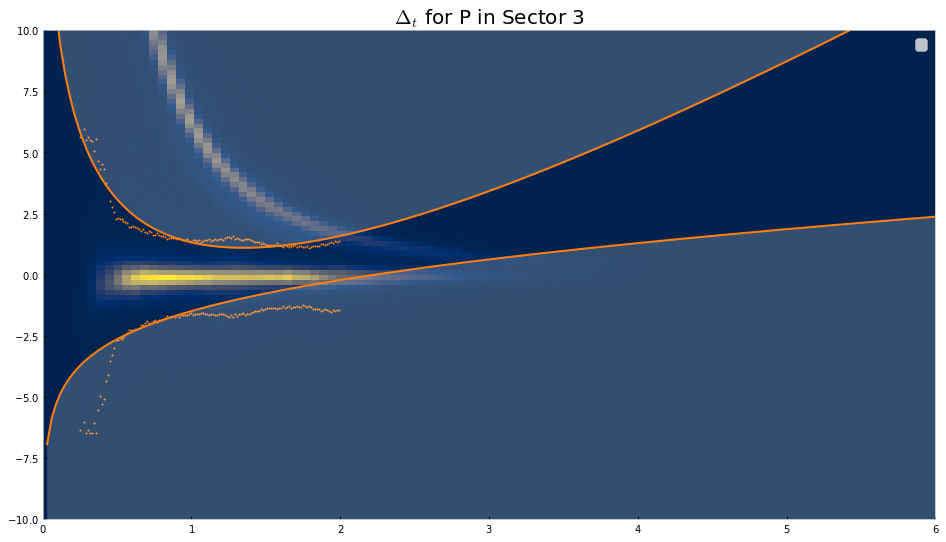

No handles with labels found to put in legend.


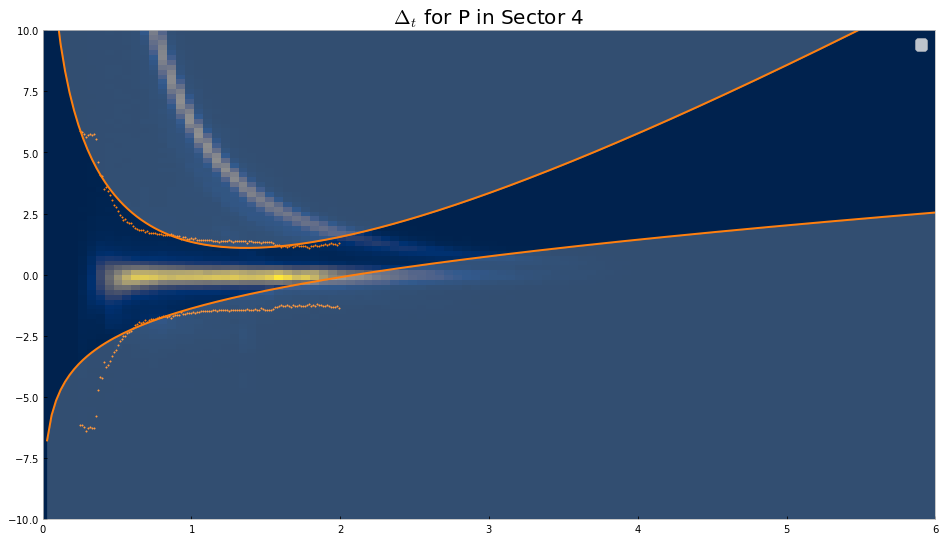

No handles with labels found to put in legend.


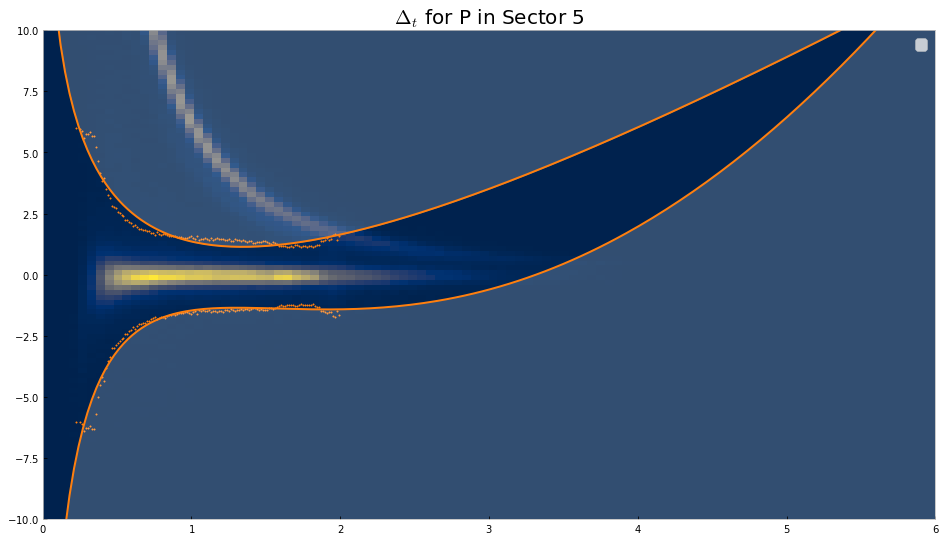

No handles with labels found to put in legend.


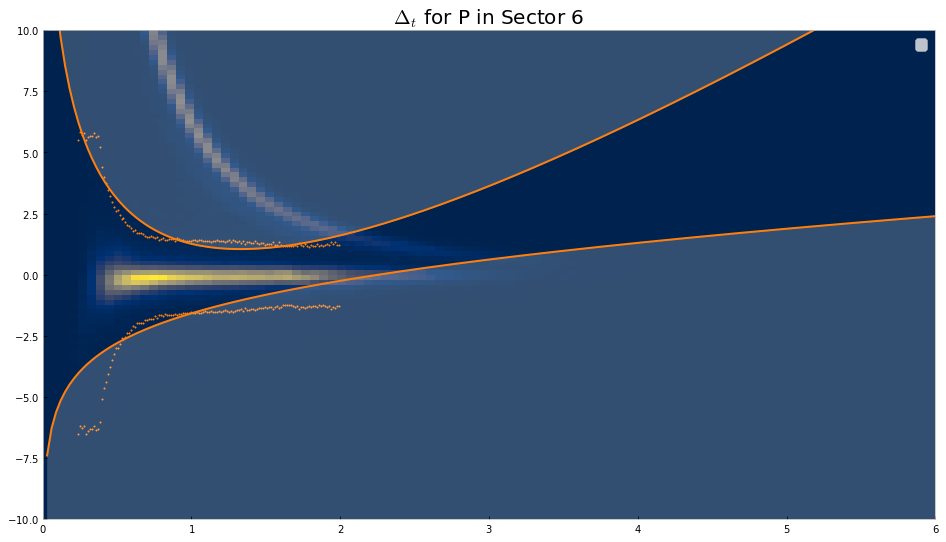

In [10]:
for part in ["dt_PIP", "dt_P"]:
    for i in range(0,7):
        n_sigma = 6
        slices = get_slices(data, min_p = 0.0, max_p = 2.0, num_steps = 150, sec=i, particle=part)
        slice_p = slices[0][slices[2] > 0.05]
        mu = slices[1][slices[2] > 0.05]
        sigma = slices[2][slices[2] > 0.05]

        fig = plt.figure(figsize=(16,9))
        plt.title(f"$\Delta_t$ for {part[3:]} in Sector {i}")
        if i != 0:
            plt.hist2d(data[data.sec == i].p, data[data.sec == i][part], bins=100, range=((0, 6.0),(-10.0,10.0)), cmap='cividis')
        else:
            plt.hist2d(data.p, data[part], bins=200, range=((0, 6.0),(-10.0,10.0)), cmap='cividis')
            
        #plt.scatter(slice_p, mu, s=2.0, c='#bcbd22')
        plt.scatter(slice_p, mu+n_sigma*sigma, s=2.0, c='#ff7f0e')
        plt.scatter(slice_p, mu-n_sigma*sigma, s=2.0, c='#ff7f0e')
        
        xdata = np.linspace(0,6.0,200)
        popt_top, pcov_top = curve_fit(log_pol1, slice_p, mu+n_sigma*sigma)
        plt.plot(xdata, log_pol1(xdata, *popt_top), c='#ff7f0e')
                 #,label=f'top\t{popt_top[0]:0.2f} $x^3$ + {popt_top[1]:0.2f} $x^2$ + {popt_top[2]:0.2f} x + {popt_top[3]:0.2f}')

        popt_bottom, pcov_bottom = curve_fit(log_pol1, slice_p, mu-n_sigma*sigma)
        plt.plot(xdata, log_pol1(xdata, *popt_bottom), c='#ff7f0e')
                 #,label=f'bottom\t{popt_bottom[0]:0.2f} $x^3$ + {popt_bottom[1]:0.2f} $x^2$ + {popt_bottom[2]:0.2f} x + {popt_bottom[3]:0.2f}')

        
        plt.fill_between(xdata, log_pol1(xdata, *popt_top), 10, alpha=0.2, color='white')
        plt.fill_between(xdata, log_pol1(xdata, *popt_bottom), -10, alpha=0.2, color='white')
        plt.legend()
        
        
        plt.show()
        
        #print(f"{i} top {part[3:]} {{{popt_top[0]},{popt_top[1]},{popt_top[2]},{popt_top[3]},{popt_top[4]}}}")
        #print(f"{i} bottom {part[3:]} {{{popt_bottom[0]},{popt_bottom[1]},{popt_bottom[2]},{popt_bottom[3]},{popt_bottom[4]}}}")
        

{ 0.15380391822372916,0.5737877438973994,0.5625238783895983,1.3323560227621674e-15,0.36208106561239845,0.5086525682152255}
0.1538 & 0.5738 & 0.5625 & 1.3324e-15 & 0.3621 & 0.5087
{ 0.7163406410186476,0.6009957526957302,0.7391348789199494,0.5274172626886494,-1.5620321206083863,0.6461690845673097}
0.7163 & 0.6010 & 0.7391 & 0.5274 & -1.5620 & 0.6462


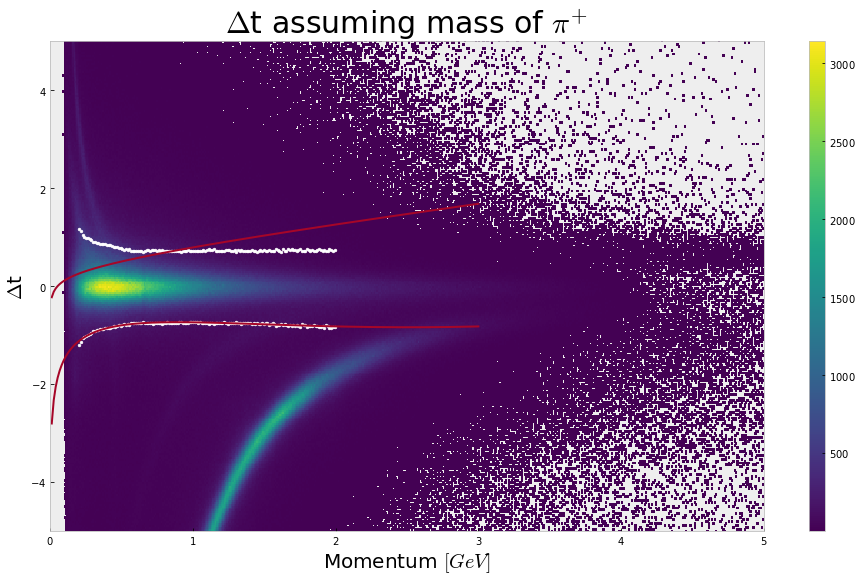

In [11]:
# slices = get_slices(data, sec=0, charge=1, min_p = 0.2, max_p = 2.5, num_steps = 200, particle="dt_PIP", show=True)
slices = get_slices(data, sec=0, charge=1, min_p = 0.2, max_p = 2.0, num_steps = 150, particle="dt_PIP", show=False)

slice_p = slices[0]
mu = slices[1]
sigma = slices[2]
NSIGMA = 3

fig = plt.figure(figsize=(16,9))
xdata = np.linspace(0,3.0,220)

dt_pip = up.open("/Users/tylern/Desktop/show/today.root:Delta_T/delta_t_mass_PIP")
hist_dt = Hist2D(boost_hist=dt_pip.to_boost(), name="Momentum$~[GeV]$")
hist_dt.plot(zeros=False, density=False)

# plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 4.0),(-5.0,5.0)))
#plt.scatter(slice_p, mu, c='#ff7f0e', s=1)
plt.scatter(slice_p, mu+NSIGMA*sigma, c='w',s=8)
plt.scatter(slice_p, mu-NSIGMA*sigma, c='w',s=8)

popt, pcov = curve_fit(log_pol1, slice_p, mu+NSIGMA*sigma)
print(f"{{ {popt[0]},{popt[1]},{popt[2]},{popt[3]},{popt[4]},{popt[5]}}}")
print(f"{popt[0]:0.4f} & {popt[1]:0.4f} & {popt[2]:0.4f} & {popt[3]:0.4e} & {popt[4]:0.4f} & {popt[5]:0.4f}")

plt.plot(xdata, log_pol1(xdata, *popt), c=COLOR_RED)


popt, pcov = curve_fit(log_pol1, slice_p, mu-NSIGMA*sigma)
print(f"{{ {popt[0]},{popt[1]},{popt[2]},{popt[3]},{popt[4]},{popt[5]}}}")
print(f"{popt[0]:0.4f} & {popt[1]:0.4f} & {popt[2]:0.4f} & {popt[3]:0.4f} & {popt[4]:0.4f} & {popt[5]:0.4f}")


plt.plot(xdata, log_pol1(xdata, *popt), c=COLOR_RED)
plt.xlabel(r"Momentum $[GeV]$",fontsize=20)
plt.ylabel(r"$\Delta$t",fontsize=20)
plt.title(r"$\Delta$t assuming mass of $\pi^{+}$", fontsize=30)
plt.ylim(top=5.0,bottom=-5.0)
# plt.colorbar()
plt.show()

#print(f"{i} top {part[3:]} {{{popt_top[0]},{popt_top[1]},{popt_top[2]},{popt_top[3]},{popt_top[4]}}}")
#print(f"{i} bottom {part[3:]} {{{popt_bottom[0]},{popt_bottom[1]},{popt_bottom[2]},{popt_bottom[3]},{popt_bottom[4]}}}")



{ -1.210210776227144,0.8083631114969356,0.5699483004181497,1.3727146399825622e-13,0.6863983929618753,0.02630558493317906}
{ 0.7473737853971132,0.1632843454289624,0.5786743400563827,3.974703454924391e-15,0.17871978728760482,-0.17547183012388615}


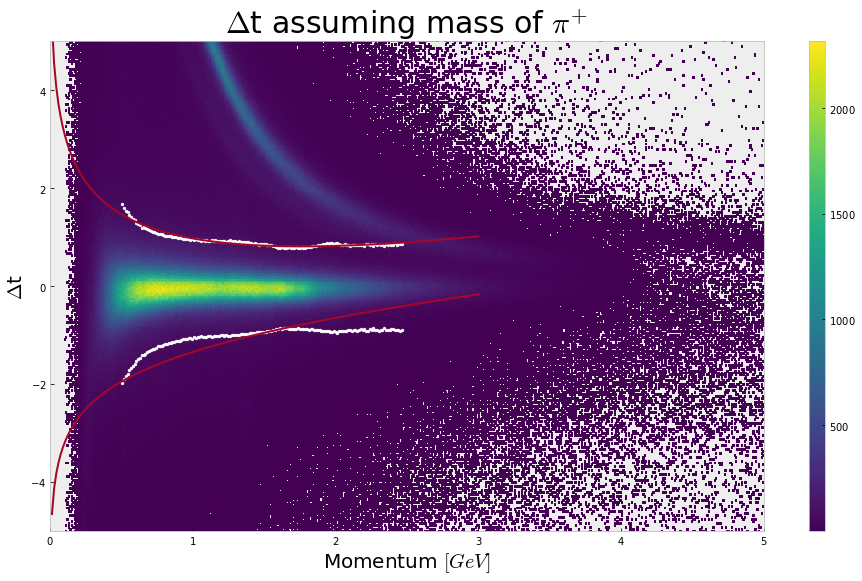

In [12]:
# slices = get_slices(data, sec=0, charge=1, min_p = 0.2, max_p = 2.5, num_steps = 200, particle="dt_PIP", show=True)
slices = get_slices(data, sec=0, charge=1, min_p = 0.5, max_p = 3.0, num_steps = 200, particle="dt_P", show=False)

slice_p = slices[0]
mu = slices[1]
sigma = slices[2]


fig = plt.figure(figsize=(16,9))
xdata = np.linspace(0,3.0,200)

dt_pip = up.open("/Users/tylern/Desktop/show/today.root:Delta_T/delta_t_mass_P")
hist_dt = Hist2D(boost_hist=dt_pip.to_boost(), name="Momentum$~[GeV]$")
hist_dt.plot(zeros=False, density=False)

# plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 4.0),(-5.0,5.0)))
#plt.scatter(slice_p, mu, c='#ff7f0e', s=1)
plt.scatter(slice_p, mu+4*sigma, c='w',s=8)
plt.scatter(slice_p, mu-4*sigma, c='w',s=8)

popt, pcov = curve_fit(log_pol1, slice_p, mu+4*sigma)
print(f"{{ {popt[0]},{popt[1]},{popt[2]},{popt[3]},{popt[4]},{popt[5]}}}")

plt.plot(xdata, log_pol1(xdata, *popt), c=COLOR_RED)


popt, pcov = curve_fit(log_pol1, slice_p, mu-4*sigma)
print(f"{{ {popt[0]},{popt[1]},{popt[2]},{popt[3]},{popt[4]},{popt[5]}}}")

plt.plot(xdata, log_pol1(xdata, *popt), c=COLOR_RED)
plt.xlabel(r"Momentum $[GeV]$",fontsize=20)
plt.ylabel(r"$\Delta$t",fontsize=20)
plt.title(r"$\Delta$t assuming mass of $\pi^{+}$", fontsize=30)
plt.ylim(top=5.0,bottom=-5.0)
# plt.colorbar()
plt.show()

#print(f"{i} top {part[3:]} {{{popt_top[0]},{popt_top[1]},{popt_top[2]},{popt_top[3]},{popt_top[4]}}}")
#print(f"{i} bottom {part[3:]} {{{popt_bottom[0]},{popt_bottom[1]},{popt_bottom[2]},{popt_bottom[3]},{popt_bottom[4]}}}")



In [13]:
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r,dt_P,dt_PIP,dt_KAON
0,5.0,0.673603,-2.473710,-1.0,51.7974,0.882316,68.8019,505.513,7.609894,0.067261,2.317635
1,1.0,1.000850,1.895650,1.0,56.9760,0.527272,73.6819,485.990,16.384014,0.063297,5.501411
2,4.0,1.167810,-1.890120,1.0,51.4494,0.426896,65.6514,464.723,23.229328,2.106949,9.497238
5,3.0,0.285894,-0.760889,1.0,54.7548,2.263920,72.7552,498.357,-0.005890,-1.345444,-0.986359
6,3.0,0.880925,-0.758683,1.0,54.7548,0.471126,71.5546,480.188,18.895100,-0.094372,6.400612


[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 241
    # data points      = 2000
    # variables        = 8
    chi-square         = 8.8531e+09
    reduced chi-square = 4444337.23
    Akaike info crit   = 30622.2666
    Bayesian info crit = 30667.0738
##  Warning: uncertainties could not be estimated:
    exp_amplitude:  at initial value
    exp_decay:      at initial value
[[Variables]]
    exp_amplitude:  1359.37697 (init = 1359.377)
    exp_decay:      2.85544573 (init = 2.855446)
    g1_amplitude:   17827.0039 (init = 1)
    g1_center:     -0.02340219 (init = 0)
    g1_sigma:       0.26033958 (init = 1)
    g1_fwhm:        0.61305286 == '2.3548200*g1_sigma'
    g1_height:      27317.9586 == '0.3989423*g1_amplitude/max(2.220446049250313e-16, g1_sigma)'
    g2_amplitude:   158040.962 (init = 1)
    g2_center:     -322767.154 (init = 0)
    g2_sigma:       1415.93677 (init = 1)


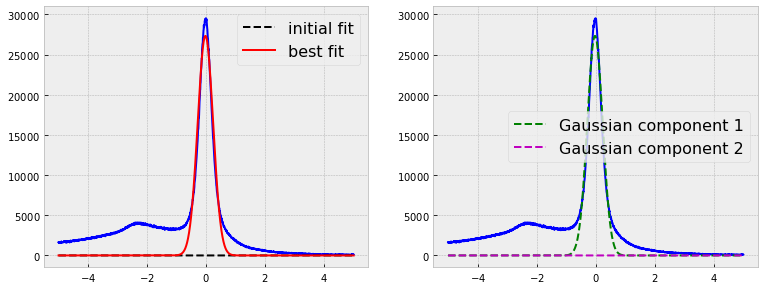

In [14]:
y, x = np.histogram(data.dt_PIP, bins=2000, range=(-5,5))
x = (x[1:]+x[:-1])/2.0


exp_mod = ExponentialModel(prefix='exp_')
pars = exp_mod.guess(y, x=x)

gauss1 = GaussianModel(prefix='g1_')
pars.update(gauss1.make_params())

#pars['g1_center'].set(value=0, min=75, max=125)
#pars['g1_sigma'].set(value=15, min=3)
#pars['g1_amplitude'].set(value=2000, min=10)

gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

mod = gauss1 + gauss2

init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y, 'b')
axes[0].plot(x, init, 'k--', label='initial fit')
axes[0].plot(x, out.best_fit, 'r-', label='best fit')
axes[0].legend(loc='best')

comps = out.eval_components(x=x)
axes[1].plot(x, y, 'b')
axes[1].plot(x, comps['g1_'], 'g--', label='Gaussian component 1')
axes[1].plot(x, comps['g2_'], 'm--', label='Gaussian component 2')
#axes[1].plot(x, comps['exp_'], 'k--', label='Exponential component')
axes[1].legend(loc='best')

plt.show()

{ -0.6560128727952385,0.038007836496801284,-0.20402794694480514,1.0819416707905776,-2.315858449178491 }
-0.6560 & 0.0380 & -0.2040 & 1.0819 & -2.3159
{ 0.6492838803633588,0.8903218482694504,0.16893058331904262,-1.0309006861889285,0.19258466205234243 }
0.6493 & 0.8903 & 0.1689 & -1.0309 & 0.1926


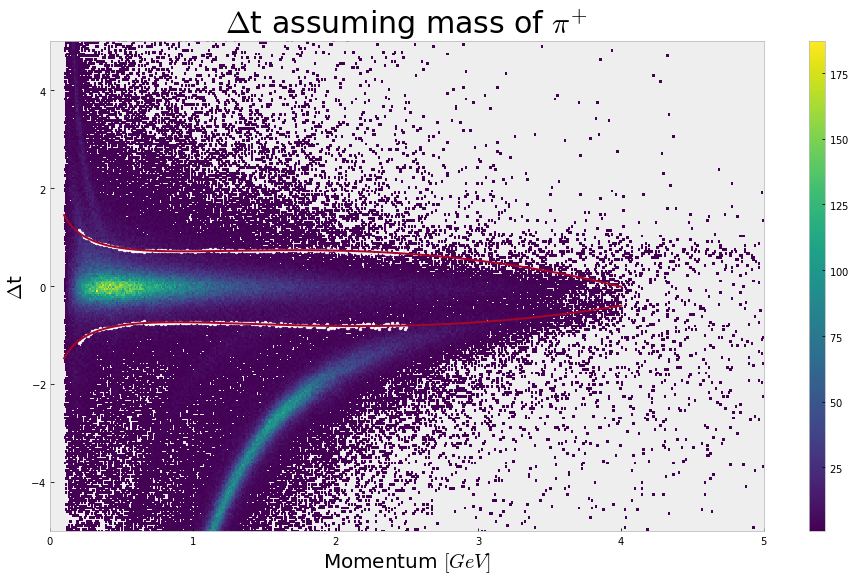

In [17]:
def new_fit(x, a, b, c, d, e):
    y = a*np.log(b*x) + c*x**2 + d*x + e
    return y


slices = get_slices(data, sec=0, charge=1, min_p = 0.2, max_p = 2.5, num_steps = 250, particle="dt_PIP", show=False)
slice_p = slices[0]
mu = slices[1]
sigma = slices[2]
NSIGMA = 3

fig = plt.figure(figsize=(16,9))
xdata = np.linspace(0.1,4.0,220)

dt_pip = up.open("/Users/tylern/Desktop/show/Full.root:Delta_T/delta_t_mass_PIP")
hist_dt = Hist2D(boost_hist=dt_pip.to_boost(), name="Momentum$~[GeV]$")
hist_dt.plot(zeros=False, density=False)


plt.scatter(slice_p, mu+NSIGMA*sigma, c='w',s=8)
plt.scatter(slice_p, mu-NSIGMA*sigma, c='w',s=8)

pip_top_mod = Model(new_fit)
top_params = pip_top_mod.make_params(a=1,b=1,c=1,d=1,e=1)
top_params['b'].set(value=1, min=0)
top_result = pip_top_mod.fit(mu+NSIGMA*sigma, top_params, x=slice_p)

plt.plot(xdata, top_result.eval(x=xdata), c=COLOR_RED)
print(f"{{ {top_result.params['a'].value},{top_result.params['b'].value},{top_result.params['c'].value},{top_result.params['d'].value},{top_result.params['e'].value} }}")
print(f"{top_result.params['a'].value:0.4f} & {top_result.params['b'].value:0.4f} & {top_result.params['c'].value:0.4f} & {top_result.params['d'].value:0.4f} & {top_result.params['e'].value:0.4f}")

pip_bot_mod = Model(new_fit)
bot_params = pip_top_mod.make_params(a=1,b=1,c=1,d=1,e=1)
bot_params['b'].set(value=1, min=0)
bot_result = pip_top_mod.fit(mu-NSIGMA*sigma, bot_params, x=slice_p)

plt.plot(xdata, bot_result.eval(x=xdata), c=COLOR_RED)
print(f"{{ {bot_result.params['a'].value},{bot_result.params['b'].value},{bot_result.params['c'].value},{bot_result.params['d'].value},{bot_result.params['e'].value} }}")
print(f"{bot_result.params['a'].value:0.4f} & {bot_result.params['b'].value:0.4f} & {bot_result.params['c'].value:0.4f} & {bot_result.params['d'].value:0.4f} & {bot_result.params['e'].value:0.4f}")


plt.xlabel(r"Momentum $[GeV]$",fontsize=20)
plt.ylabel(r"$\Delta$t",fontsize=20)
plt.title(r"$\Delta$t assuming mass of $\pi^{+}$", fontsize=30)
plt.ylim(top=5.0,bottom=-5.0)
# plt.colorbar()
plt.show()



{ -1.5923979426319816,0.1531213624061054,-0.21636712299166508,1.680251374186574,-3.7607840931549705 }
-1.5924 & 0.1531 & -0.2164 & 1.6803 & -3.7608
{ 2.4996117021472184,1.0578491775246746,0.39418249343997863,-2.803723909869658,1.4585721659792854 }
2.4996 & 1.0578 & 0.3942 & -2.8037 & 1.4586


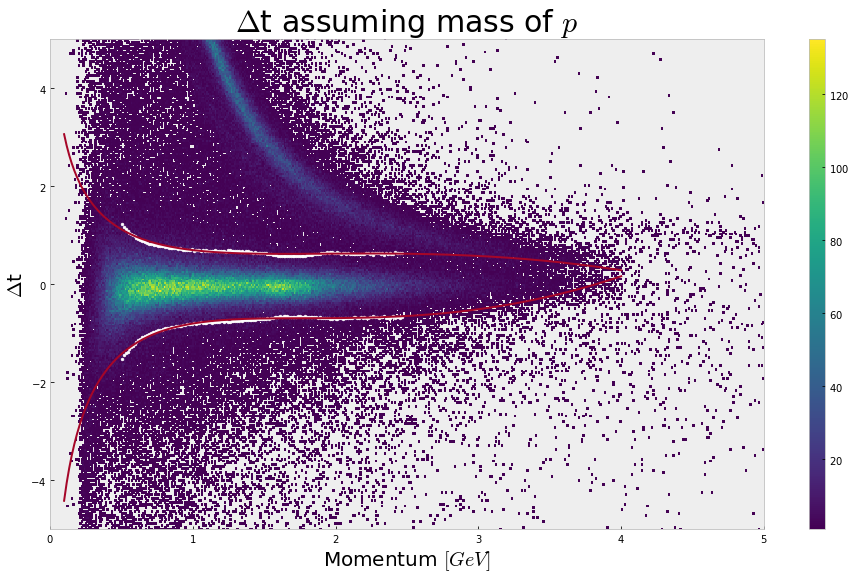

In [18]:
fig = plt.figure(figsize=(16,9))

slices = get_slices(data, sec=0, charge=1, min_p = 0.5, max_p = 3.0, num_steps = 200, particle="dt_P", show=False)

slice_p = slices[0]
mu = slices[1]
sigma = slices[2]


dt_pip = up.open("/Users/tylern/Desktop/show/Full.root:Delta_T/delta_t_mass_P")
hist_dt = Hist2D(boost_hist=dt_pip.to_boost(), name="Momentum$~[GeV]$")
hist_dt.plot(zeros=False, density=False)


plt.scatter(slice_p, mu+NSIGMA*sigma, c='w',s=8)
plt.scatter(slice_p, mu-NSIGMA*sigma, c='w',s=8)

pip_top_mod = Model(new_fit)
top_params = pip_top_mod.make_params(a=1,b=1,c=1,d=1,e=1)
top_params['b'].set(value=1, min=0)
top_result = pip_top_mod.fit(mu+NSIGMA*sigma, top_params, x=slice_p)

plt.plot(xdata, top_result.eval(x=xdata), c=COLOR_RED)
print(f"{{ {top_result.params['a'].value},{top_result.params['b'].value},{top_result.params['c'].value},{top_result.params['d'].value},{top_result.params['e'].value} }}")
print(f"{top_result.params['a'].value:0.4f} & {top_result.params['b'].value:0.4f} & {top_result.params['c'].value:0.4f} & {top_result.params['d'].value:0.4f} & {top_result.params['e'].value:0.4f}")

pip_bot_mod = Model(new_fit)
bot_params = pip_top_mod.make_params(a=1,b=1,c=1,d=1,e=1)
bot_params['b'].set(value=1, min=0)
bot_result = pip_top_mod.fit(mu-NSIGMA*sigma, bot_params, x=slice_p)

plt.plot(xdata, bot_result.eval(x=xdata), c=COLOR_RED)
print(f"{{ {bot_result.params['a'].value},{bot_result.params['b'].value},{bot_result.params['c'].value},{bot_result.params['d'].value},{bot_result.params['e'].value} }}")
print(f"{bot_result.params['a'].value:0.4f} & {bot_result.params['b'].value:0.4f} & {bot_result.params['c'].value:0.4f} & {bot_result.params['d'].value:0.4f} & {bot_result.params['e'].value:0.4f}")


plt.xlabel(r"Momentum $[GeV]$",fontsize=20)
plt.ylabel(r"$\Delta$t",fontsize=20)
plt.title(r"$\Delta$t assuming mass of $p$", fontsize=30)
plt.ylim(top=5.0,bottom=-5.0)
# plt.colorbar()
plt.show()